In [1]:
# Install RDKit.
%%capture
!pip install rdkit

In [6]:
pip install chembl-structure-pipeline

In [7]:
pip install MolVS

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import chembl_structure_pipeline
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import joblib
import pickle
from numpy import savetxt
from IPython.display import HTML
from rdkit.Chem import PandasTools

[14:48:56] Initializing Normalizer


In [11]:
sdfFile='/content/KRAS_work_from_insilico.sdf'

In [12]:
df = PandasTools.LoadSDF(sdfFile,smilesName='SMILES',molColName='Structure', includeFingerprints=False)
# df=df.drop(['ID'], axis=1)
HTML(df.head().to_html())

,id,SMILES,KRAS G12D binding IC50 (nM),canonical_smiles,pIC50,pIC50_mean,pIC50_std,ID,Structure
0,83,O=C1CCC2(COc3nc(N4CC5CCC(C4)N5)c4cnc(-c5cccc6cccc(Cl)c56)c(F)c4n3)CCCN12,8694.900391,O=C1CCC2(COc3nc(N4CC5CCC(C4)N5)c4cnc(-c5cccc6cccc(Cl)c56)c(F)c4n3)CCCN12,5.060735,5.060735,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc33c65e0>
1,62,O=Cc1cc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5cccc(Cl)c45)c(F)c3n2)ccc1O,8407.400391,O=Cc1cc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5cccc(Cl)c45)c(F)c3n2)ccc1O,5.075338,5.075338,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc33c6f10>
2,261,NCCOc1nc(N2CC3CCC(C2)N3)c2cnc(-c3cccc4cccc(Cl)c34)c(F)c2n1,8304.200195,NCCOc1nc(N2CC3CCC(C2)N3)c2cnc(-c3cccc4cccc(Cl)c34)c(F)c2n1,5.080702,5.080702,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc33c7760>
3,101,Cc1cccc2cccc(-c3ncc4c(N5CC6CCC(C5)N6)nc(OCCc5cccnc5)nc4c3F)c12,8081.600098,Cc1cccc2cccc(-c3ncc4c(N5CC6CCC(C5)N6)nc(OCCc5cccnc5)nc4c3F)c12,5.092503,5.092503,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc33c77d0>
4,402,CC(C)(O)c1ccccc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34CCCN3CC(F)C4)nc2c1F,8017.600098,CC(C)(O)c1ccccc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34CCCN3CC(F)C4)nc2c1F,5.095956,5.095956,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc33c7920>


In [13]:
df.dtypes

,0
id,object
SMILES,object
KRAS G12D binding IC50 (nM),object
canonical_smiles,object
pIC50,object
pIC50_mean,object
pIC50_std,object
ID,object
Structure,object


In [14]:
df['pIC50_mean']=df['pIC50_mean'].astype(float)

In [16]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumHAcceptors = Descriptors.NumHAcceptors(mol)
        desc_NumHDonors = Descriptors.NumHDonors(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_TPSA=Descriptors.TPSA(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumHAcceptors,
                        desc_NumHDonors,
                        desc_NumRotatableBonds,
                        desc_TPSA])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["LogP","MW","NumHAcceptors", 'NumHDonors', 'NumRotatableBonds', 'TPSA']
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [18]:
df_desc_ws = generate(df.SMILES)
df_desc_ws

,LogP,MW,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA
0,5.11190,573.072,7.0,1.0,5.0,83.48
1,5.71770,584.051,8.0,2.0,7.0,100.47
2,3.91560,478.959,7.0,2.0,5.0,89.19
3,5.24962,520.612,7.0,1.0,6.0,76.06
4,3.95410,550.654,8.0,2.0,6.0,86.64
...,...,...,...,...,...,...
447,4.56680,582.655,8.0,2.0,5.0,86.64
448,5.11910,667.761,9.0,1.0,7.0,95.95
449,4.70590,600.645,8.0,2.0,5.0,86.64
450,4.61880,564.665,8.0,2.0,5.0,86.64


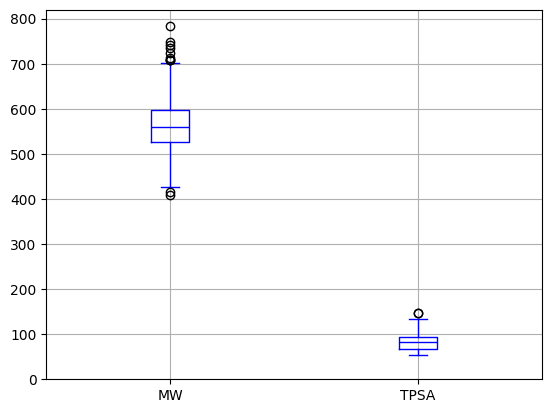

In [19]:
plt1=df_desc_ws.boxplot(column=['MW','TPSA'], grid= True , color='blue')
plt1.grid(True)
plt1.set_yticks(np.arange(0,900,100))

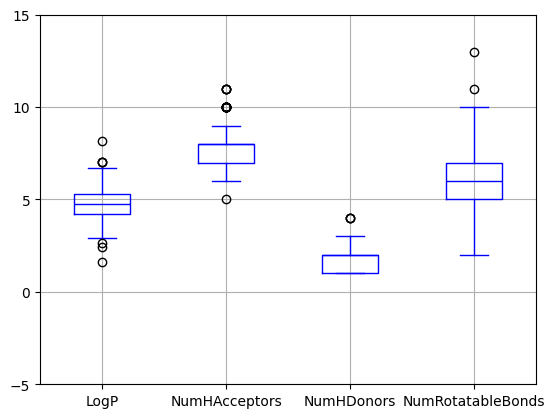

In [21]:
plt=df_desc_ws.boxplot(column=['LogP', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds'], grid= True , color='blue')
plt.grid(True)
plt.set_yticks(np.arange(-5,20,5))

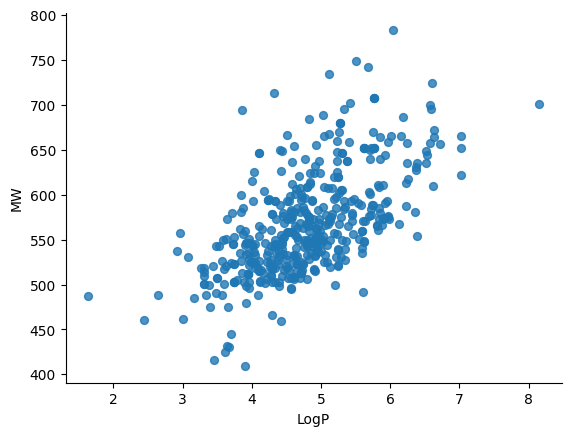

In [22]:
# @title LogP vs MW

from matplotlib import pyplot as plt
df_desc_ws.plot(kind='scatter', x='LogP', y='MW', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

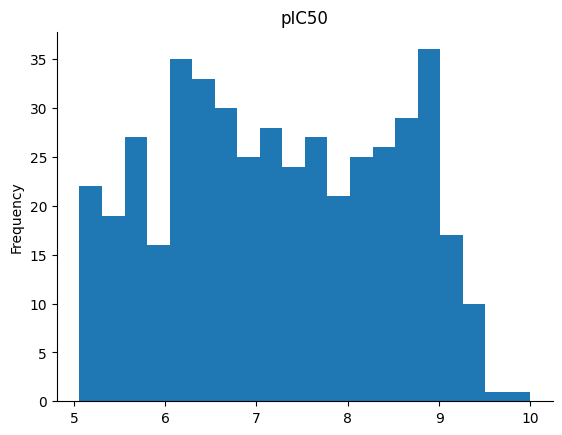

In [23]:
# @title pIC50
from matplotlib import pyplot as plt
df['pIC50_mean'].plot(kind='hist', bins=20, title='pIC50')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [24]:
sdfFile_ts='/content/KRAS_test_from_insilico.sdf'

In [25]:
df_ts = PandasTools.LoadSDF(sdfFile_ts,smilesName='SMILES',molColName='Structure', includeFingerprints=False)
# df_ts=df_ts.drop(['ID'], axis=1)
HTML(df_ts.head().to_html())

,id,SMILES,KRAS G12D binding IC50 (nM),canonical_smiles,pIC50,pIC50_mean,pIC50_std,ID,Structure
0,142,Fc1c(-c2cccc3cccc(Cl)c23)ncc2c(N3CC4CCC(C3)N4)nc(OC3CCc4[nH]ncc4C3)nc12,8846.400391,Fc1c(-c2cccc3cccc(Cl)c23)ncc2c(N3CC4CCC(C3)N4)nc(OC3CCc4[nH]ncc4C3)nc12,5.053234,5.053234,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc343e260>
1,138,COC(C)COc1nc(N2CC3CCC(C2)N3)c2cnc(-c3cccc4cccc(Cl)c34)c(F)c2n1,8067.799805,COC(C)COc1nc(N2CC3CCC(C2)N3)c2cnc(-c3cccc4cccc(Cl)c34)c(F)c2n1,5.093245,5.093245,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc343e810>
2,421,CC(C)c1ncccc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34CCCN3CC(F)C4)nc2c1F,7746.700195,CC(C)c1ncccc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34CCCN3CC(F)C4)nc2c1F,5.110883,5.110883,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc343e880>
3,577,CN1CCCC1COc1nc2c(c(N3CC4CCC(C3)N4)n1)CCN(c1c(F)c(O)c(F)c3ccccc13)C2,6788.200195,CN1CCCC1COc1nc2c(c(N3CC4CCC(C3)N4)n1)CCN(c1c(F)c(O)c(F)c3ccccc13)C2,5.168245,5.168245,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc343eab0>
4,147,Fc1c(-c2cccc3cccc(Cl)c23)ncc2c(N3CC4CCC(C3)N4)nc(OCCn3cccn3)nc12,5876.200195,Fc1c(-c2cccc3cccc(Cl)c23)ncc2c(N3CC4CCC(C3)N4)nc(OCCn3cccn3)nc12,5.230904,5.230904,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7b1dc343ec00>


In [26]:
df_ts['pIC50_mean']=df_ts['pIC50_mean'].astype(float)

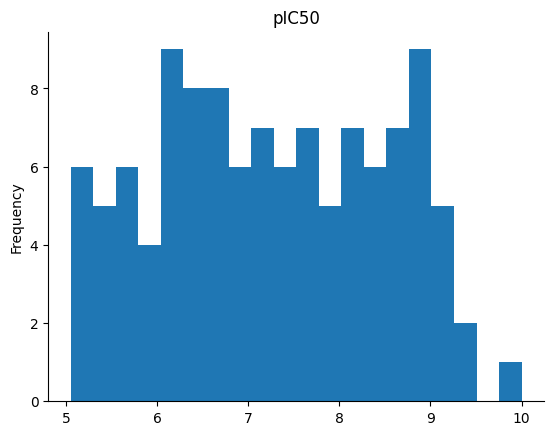

In [27]:
from matplotlib import pyplot as plt
df_ts['pIC50_mean'].plot(kind='hist', bins=20, title='pIC50')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
df_desc_ts = generate(df_ts.SMILES)
df_desc_ts

,LogP,MW,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA
0,5.2375,556.045,7.0,2.0,4.0,91.85
1,4.9918,507.997,7.0,1.0,6.0,72.40
2,4.2451,535.643,8.0,1.0,6.0,79.30
3,3.5899,536.627,8.0,2.0,5.0,76.99
4,4.8536,530.007,8.0,1.0,6.0,80.99
...,...,...,...,...,...,...
109,4.3829,574.579,9.0,2.0,6.0,95.87
110,4.7246,576.623,8.0,2.0,5.0,86.64
111,5.4058,687.792,10.0,2.0,8.0,116.18
112,4.7567,549.050,8.0,2.0,5.0,86.64


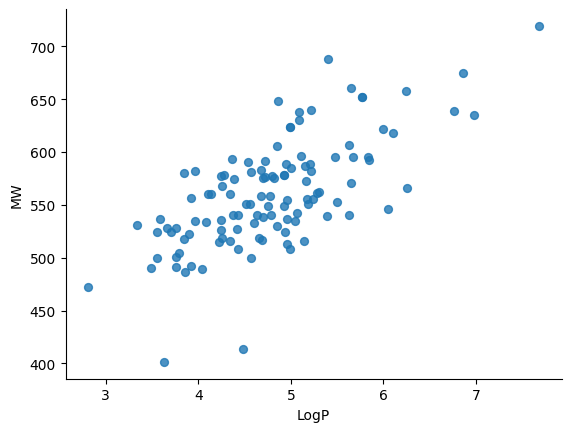

In [29]:
from matplotlib import pyplot as plt
df_desc_ts.plot(kind='scatter', x='LogP', y='MW', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

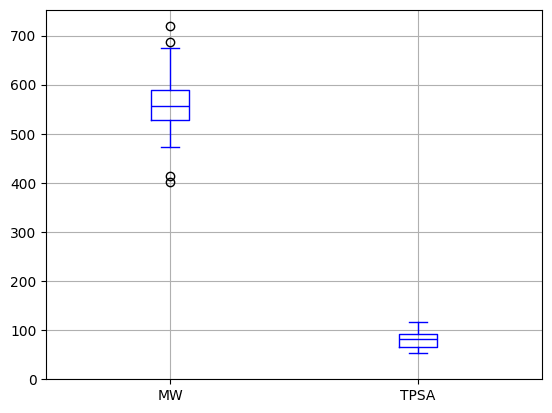

In [30]:
plt1_ts=df_desc_ts.boxplot(column=['MW','TPSA'], grid= True , color='blue')
plt1_ts.grid(True)
plt1_ts.set_yticks(np.arange(0,800,100))

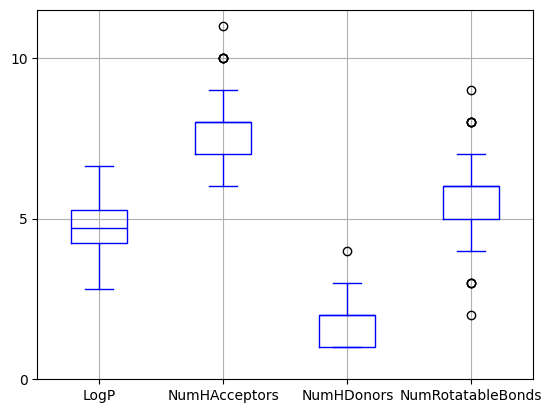

In [ ]:
plt_ts=df_desc_ts.boxplot(column=['LogP', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds'], grid= True , color='blue')
plt_ts.grid(True)
plt_ts.set_yticks(np.arange(0,15,5))

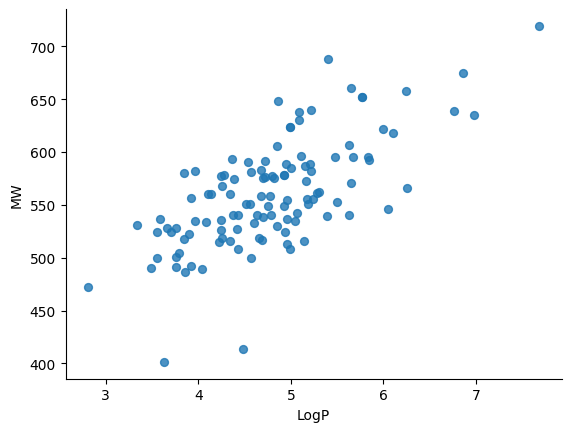

In [31]:
from matplotlib import pyplot as plt
df_desc_ts.plot(kind='scatter', x='LogP', y='MW', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

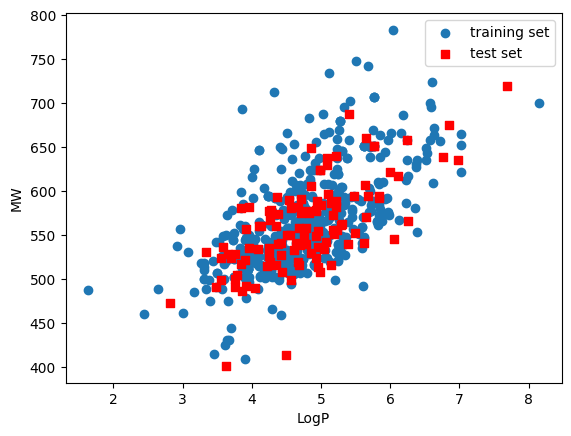

In [32]:
fig, ax = plt.subplots()
ax.scatter(df_desc_ws['LogP'], df_desc_ws['MW'], label='training set')
ax.scatter(df_desc_ts['LogP'], df_desc_ts['MW'], label='test set', marker='s', color='r')
ax.legend()
ax.set_xlabel('LogP')
ax.set_ylabel('MW')
# ax.set_title('Multiple Datasets Scatter Plot')
plt.show()

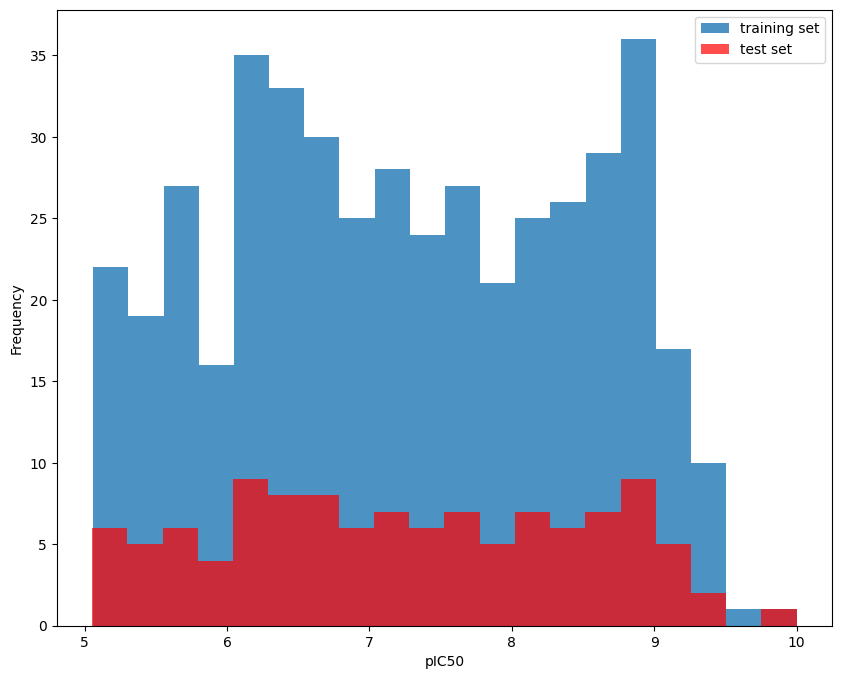

In [33]:
# plotting first histogram
plt.figure(figsize=(10,8))
plt.hist(df['pIC50_mean'], label='training set', alpha=.8,  bins=20)

# plotting second histogram
plt.hist(df_ts['pIC50_mean'], label='test set', alpha=0.7,  bins=20, color='r')
plt.legend()

plt.xlabel('pIC50')
plt.ylabel('Frequency')

# Showing the plot using plt.show()
plt.show()